## The Notepad 📝

📆 Match day: 20th of March 2022. 

This notebook supports the research behind this blogpost.

------------------

**Disclaimer:** All code is for educational and personal purposes only. This is not ivestment or betting advice.

In [280]:
from data.sources.fotmob.extractor import *
from models.model_1 import *
import os
import urllib

In [281]:
# Libraries for visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
from highlight_text import ax_text, fig_text
from PIL import Image
import seaborn as sns

In [282]:
# Add pretty fonts

for x in os.listdir("visualizations/fonts"):
    for y in os.listdir(f"visualizations/fonts/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"visualizations/fonts/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y)
            except:
                continue

plt.style.use("kellys_style.mpl")


### Empoli vs. Hellas Verona

Let's start in Italy for the first match of Sunday's games. We first get the data for all Serie A matches of the season.

In [283]:
matches = pd.read_csv("data/database/match_ids.csv")

sa_matches = matches[(matches["leagueId"] == 55) & (matches["date"] > "2021-06-15")].copy()
sa_matches.sort_values(by = "date")

,match_id,leagueId,tournamentStage,finished,cancelled,date,venue,team_id
277388,3656994,55,1,True,False,2021-08-21 18:30:00,H,9876
277389,3656995,55,1,True,False,2021-08-21 18:30:00,H,8636
277925,3656994,55,1,True,False,2021-08-21 18:30:00,A,7943
277926,3656995,55,1,True,False,2021-08-21 18:30:00,A,10233
277390,3656993,55,1,True,False,2021-08-21 20:45:00,H,8534
...,...,...,...,...,...,...,...,...
342154,3657336,55,29,True,False,2022-03-14 20:45:00,A,7881
344798,3657200,55,30,True,False,2022-03-18 18:45:00,A,9881
344645,3657200,55,30,True,False,2022-03-18 18:45:00,H,7943
344646,3657195,55,30,True,False,2022-03-18 21:00:00,H,10233


In [284]:
data = fotmob_match_stats_pool(list(sa_matches["match_id"].unique()), melted=True)

100%|██████████| 287/287 [00:53<00:00,  5.33it/s]


In [285]:
data.loc[:,"value"] = data["value"].astype(float)

We do a prediction taking into account this season's games at home and away respectively. 

In [286]:
empoli_goals = data[(data["team_name"] == "Empoli") & (data["venue"] == "H") & (data["variable"] == "xG_for")]["value"].astype(float)
hellas_goals = data[(data["team_name"] == "Hellas Verona") & (data["venue"] == "A")  & (data["variable"] == "xG_for")]["value"].astype(float)
empoli_goals_ag = data[(data["team_name"] == "Empoli") & (data["venue"] == "H")  & (data["variable"] == "xG_ag")]["value"].astype(float)
hellas_goals_ag = data[(data["team_name"] == "Hellas Verona") & (data["venue"] == "A") & (data["variable"] == "xG_ag")]["value"].astype(float)

Before we look at any data we have to assign our priors. I believe that Hellas have a stronger chance of winning this game, however, since I'm not very familiar with any of the teams I'll assign a very low weight to my priors.

In [287]:
empoli_probs = model_team_vars(empoli_goals, hellas_goals_ag, limit_x=8, alpha_1=0.75, beta_1=.05)
hellas_probs = model_team_vars(hellas_goals, empoli_goals_ag, limit_x=8, alpha_1=1.25, beta_1=.05)

In [288]:
probs = model_match_vars(empoli_probs["X1_probs"], hellas_probs["X1_probs"])
print(f"Probability of a Empoli win is of {probs['home_win_prob']:.1%}, with fair odds of {1/(probs['home_win_prob']):.2f}x")
print(f"Probability of a Hellas win is of {probs['away_win_prob']:.1%}, with fair odds of {1/(probs['away_win_prob']):.2f}x")
print(f"Probability of a Hellas double chance is of {1 - probs['away_win_prob']:.1%}, with fair odds of {1/(1 - probs['home_win_prob']):.2f}x")

Probability of a Empoli win is of 29.6%, with fair odds of 3.38x
Probability of a Hellas win is of 48.0%, with fair odds of 2.08x
Probability of a Hellas double chance is of 52.0%, with fair odds of 1.42x


In [289]:
1/(1 - (probs["result_matrix"][0,0] + probs["result_matrix"][0,1] + probs["result_matrix"][1,0]))

1.1965121089021538

A Hellas Verona win or double chance seems very attractive at odds of 2.7 and 1.5, respectively.

In [290]:
empoli_matches = data[(data["team_name"] == "Empoli") & (data["venue"] == "H")].copy()
hellas_matches = data[(data["team_name"] == "Hellas Verona") & (data["venue"] == "A")].copy()

In [291]:
test = data[data["venue"] == "A"].groupby(["variable","team_name"])["value"].mean().reset_index()
test = test.pivot(index = "team_name", columns = "variable")
test[[('value','xG_for')]].sort_values(('value','xG_for'))

,value
variable,xG_for
team_name,
Venezia,0.880714
Sampdoria,0.927143
Spezia,0.928125
Salernitana,0.928462
Cagliari,0.943333
Torino,1.045714
Genoa,1.110000
Udinese,1.210000


In [292]:
(empoli_matches[empoli_matches["variable"] == "score_for"]["value"] > 0).sum()/empoli_matches[empoli_matches["variable"] == "score_ag"].shape[0]

0.8571428571428571

c:\Users\MiguelAngel\Documents\Miguel\MadBets\football_bets\.MadBets\lib\site-packages\ipykernel_launcher.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


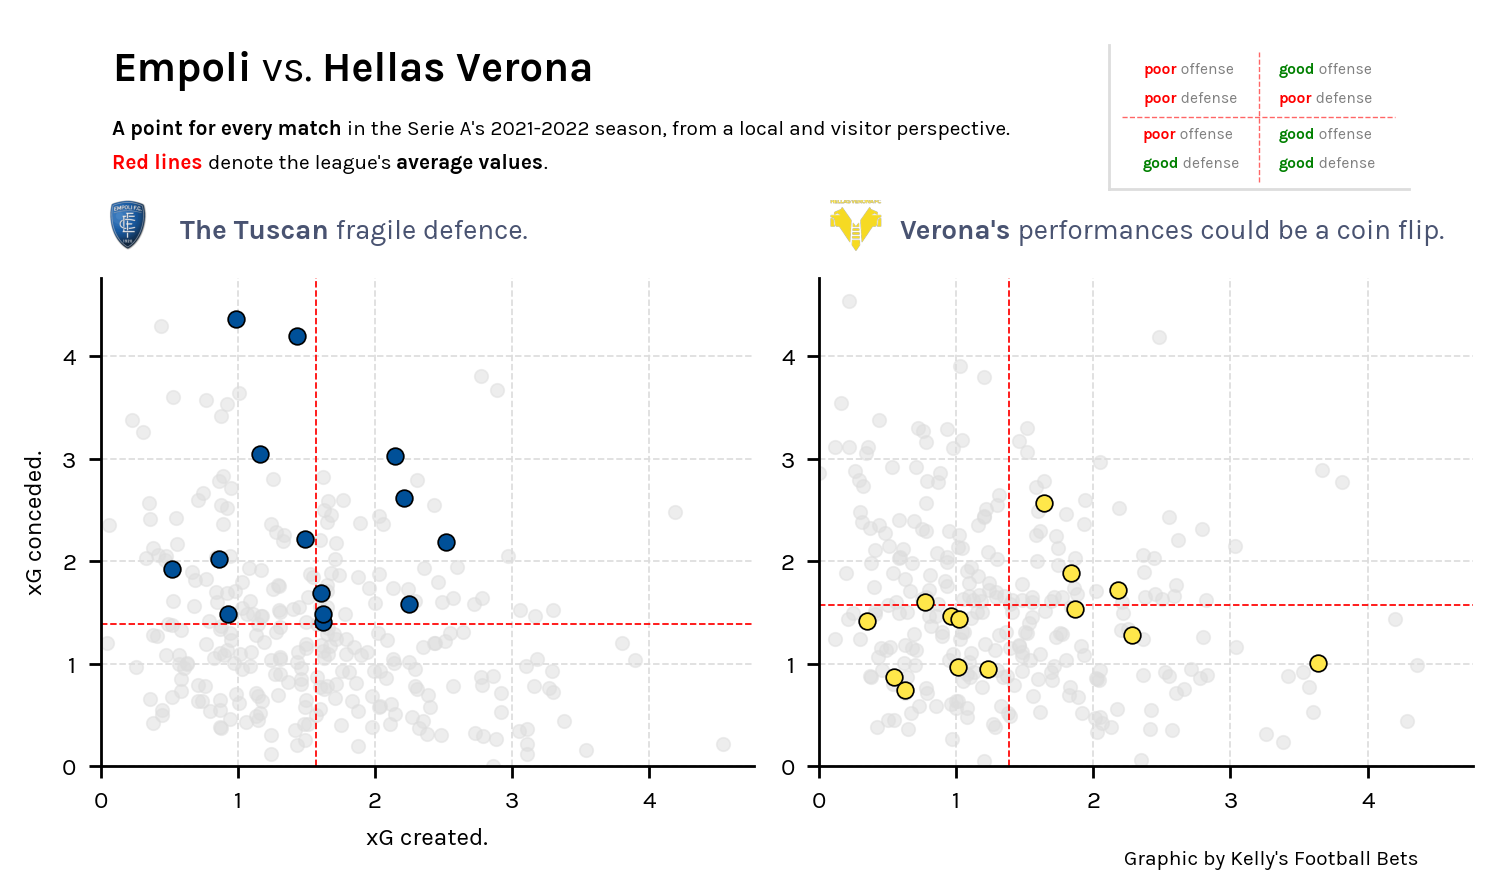

In [293]:
fig = plt.figure(figsize=(6,2.5), dpi = 250, facecolor="white")
ax = plt.subplot(121)
ax2 = plt.subplot(122)

# ax2.spines["left"].set_visible(False)
# ax2.set(yticklabels=[])  # remove the tick labels
# ax2.tick_params(left=False)

# ------------------------------------------
# Scatter plots
ax.scatter(data[(data["variable"] == "xG_for") & (data["venue"] == "H")]["value"], data[(data["variable"] == "xG_ag")  & (data["venue"] == "H")]["value"],
        zorder = 2,
        color = "#DDDDDD",
        alpha = 0.5,
        lw = 0.5,
        s = 15)
ax.scatter(empoli_matches[empoli_matches["variable"] == "xG_for"]["value"], empoli_matches[empoli_matches["variable"] == "xG_ag"]["value"],
        zorder = 3,
        color = "#005098",
        edgecolor = "black",
        lw = 0.5,
        s = 23)

ax2.scatter(data[(data["variable"] == "xG_for") & (data["venue"] == "A")]["value"], data[(data["variable"] == "xG_ag")  & (data["venue"] == "A")]["value"],
        zorder = 2,
        color = "#DDDDDD",
        alpha = 0.5,
        lw = 0.5,
        s = 15)
ax2.scatter(hellas_matches[hellas_matches["variable"] == "xG_for"]["value"], hellas_matches[hellas_matches["variable"] == "xG_ag"]["value"],
        zorder = 3,
        color = "#FFE74A",
        edgecolor = "black",
        lw = 0.5,
        s = 23)


# ------------------------------------------
# Define limits
Lim_max = max(ax.get_xlim()[1], ax.get_ylim()[1], ax2.get_xlim()[1], ax2.get_ylim()[1])
ax.set_xlim(0, Lim_max)
ax2.set_xlim(0, Lim_max)
ax.set_ylim(0, Lim_max)
ax2.set_ylim(0, Lim_max)

# ------------------------------------------
# Means

mean_for_home = data[(data["venue"] == "H") & (data["variable"] == "xG_for")]["value"].mean()
mean_ag_home = data[(data["venue"] == "H") & (data["variable"] == "xG_ag")]["value"].mean()
mean_for_away = data[(data["venue"] == "A") & (data["variable"] == "xG_for")]["value"].mean()
mean_ag_away = data[(data["venue"] == "A") & (data["variable"] == "xG_ag")]["value"].mean()

ax.plot([mean_for_home,mean_for_home],[0,Lim_max], ls = "--", color = "red", marker = "", lw = 0.5, zorder = 2)
ax.plot([0,Lim_max],[mean_ag_home,mean_ag_home], ls = "--", color = "red", marker = "", lw = 0.5, zorder = 2)

ax2.plot([mean_for_away,mean_for_away],[0,Lim_max], ls = "--", color = "red", marker = "", lw = 0.5, zorder = 2)
ax2.plot([0,Lim_max],[mean_ag_away,mean_ag_away], ls = "--", color = "red", marker = "", lw = 0.5, zorder = 2)

# ------------------------------------------
# Team icons

team_icon = Image.open(urllib.request.urlopen(f"https://images.fotmob.com/image_resources/logo/teamlogo/{8534}.png"))
team_ax = fig.add_axes([0.045, 1, 0.082, 0.082], zorder=1)
team_ax.imshow(team_icon)
team_ax.axis("off")

ax_text(x = 0.12, y = 1.08,
s = f"<The Tuscan> fragile defence.",
highlight_textprops=[{"weight":"bold"}],
ax = ax, weight = "normal", ha = "left", size = 8, color = "#495371",annotationbbox_kw = {"xycoords":"figure fraction"})

ax_text(x = 0.6, y = 1.08,
s = f"<Verona's> performances could be a coin flip.",
highlight_textprops=[{"weight":"bold"}],
ax = ax, weight = "normal", ha = "left", size = 8, color = "#495371",annotationbbox_kw = {"xycoords":"figure fraction"})


team_icon = Image.open(urllib.request.urlopen(f"https://images.fotmob.com/image_resources/logo/teamlogo/{9876}.png"))
team_ax = fig.add_axes([0.53, 1, 0.082, 0.082], zorder=1)
team_ax.imshow(team_icon)
team_ax.axis("off")

# -----------------------
# Titles and other stuff
ax.xaxis.set_label_text("xG created.")
ax.yaxis.set_label_text("xG conceded.")


ax_text(x = 0.075, y = 1.35,
        s = "<Empoli> vs. <Hellas Verona>",
        highlight_textprops=[{"weight":"bold"}, {"weight":"bold"}],
        ax = ax, weight = "normal", ha = "left", size = 12, annotationbbox_kw = {"xycoords":"figure fraction"})

ax_text(x = 0.075, y = 1.24,
        s = "<A point for every match> in the Serie A's 2021-2022 season, from a local and visitor perspective.\n<Red lines> denote the league's <average values>.",
        highlight_textprops=[{"weight":"bold"}, {"weight":"bold", "color":"red"}, {"weight":"bold"}],
        ax = ax, weight = "normal", ha = "left", size = 6, annotationbbox_kw = {"xycoords":"figure fraction"})

# -----------------------
# Legend ax
legend_ax = fig.add_axes([0.74, 1.1, 0.2, 0.23], zorder=1)
legend_ax.spines["left"].set_color("#DDDDDD")
legend_ax.spines["bottom"].set_color("#DDDDDD")
legend_ax.set_xticks([])
legend_ax.set_yticks([])
legend_ax.set_xticklabels([])
legend_ax.set_yticklabels([])
legend_ax.plot([0.5,0.5],[0,1], ls = "--", color = "red", marker = "", lw = 0.4, zorder = 2, alpha = 0.6)
legend_ax.plot([0,1],[0.5,0.5], ls = "--", color = "red", marker = "", lw = 0.4, zorder = 2, alpha = 0.6)

ax_text(x = 0.75, y = 0.75,
        s = "<good> offense \n<poor> defense",
        highlight_textprops=[{"weight":"bold","color":"green"}, {"weight":"bold","color":"red"}],
        ax = legend_ax, weight = "normal", ha = "center", color = "gray", va = "center", size = 4.5, annotationbbox_kw = {"xycoords":"data"})

ax_text(x = 0.25, y = 0.75,
        s = "<poor> offense \n<poor> defense",
        highlight_textprops=[{"weight":"bold","color":"red"}, {"weight":"bold","color":"red"}],
        ax = legend_ax, weight = "normal", ha = "center", color = "gray", va = "center", size = 4.5, annotationbbox_kw = {"xycoords":"data"})

ax_text(x = 0.25, y = 0.25,
        s = "<poor> offense \n<good> defense",
        highlight_textprops=[{"weight":"bold","color":"red"}, {"weight":"bold","color":"green"}],
        ax = legend_ax, weight = "normal", ha = "center", va = "center", color = "gray", size = 4.5, annotationbbox_kw = {"xycoords":"data"})

ax_text(x = 0.75, y = 0.25,
        s = "<good> offense \n<good> defense",
        highlight_textprops=[{"weight":"bold","color":"green"}, {"weight":"bold","color":"green"}],
        ax = legend_ax, weight = "normal", ha = "center", va = "center", color = "gray", size = 4.5, annotationbbox_kw = {"xycoords":"data"})


plt.tight_layout()
fig.text(0.75, 0.02, "Graphic by Kelly's Football Bets", fontsize=6)

plt.savefig(
f"visualizations/plots/the_notepad/03202022/empoli_verona.png",
dpi=250,
bbox_inches="tight",
edgecolor="none",
transparent=False,
)

### Leicester vs. Brentford


In [294]:
matches = pd.read_csv("data/database/match_ids.csv")

epl_matches = matches[(matches["leagueId"] == 47) & (matches["date"] > "2021-06-15")].copy()
epl_matches.sort_values(by = "date")

,match_id,leagueId,tournamentStage,finished,cancelled,date,venue,team_id
274350,3609929,47,1,True,False,2021-08-13 21:00:00,H,9937
274485,3609929,47,1,True,False,2021-08-13 21:00:00,A,9825
275556,3609934,47,1,True,False,2021-08-14 13:30:00,H,10260
276026,3609934,47,1,True,False,2021-08-14 13:30:00,A,8463
276031,3609938,47,1,True,False,2021-08-14 16:00:00,A,10252
...,...,...,...,...,...,...,...,...
344121,3610190,47,27,True,False,2022-03-16 21:15:00,A,8650
344532,3610125,47,20,True,False,2022-03-17 20:45:00,H,8668
344593,3610125,47,20,True,False,2022-03-17 20:45:00,A,10261
344640,3610229,47,30,True,False,2022-03-18 21:00:00,H,8602


In [295]:
data = fotmob_match_stats_pool(list(epl_matches["match_id"].unique()), melted=True)

100%|██████████| 285/285 [00:44<00:00,  6.36it/s]


In [296]:
data.loc[:,"value"] = data["value"].astype(float)

We do a prediction taking into account this season's games at home and away respectively. 

In [298]:
lei_goals = data[(data["team_name"] == "Leicester City") & (data["venue"] == "H") & (data["variable"] == "score_for")]["value"].astype(float)
bren_goals = data[(data["team_name"] == "Brentford") & (data["venue"] == "A")  & (data["variable"] == "score_for")]["value"].astype(float)
lei_goals_ag = data[(data["team_name"] == "Leicester City") & (data["venue"] == "H")  & (data["variable"] == "score_ag")]["value"].astype(float)
bren_goals_ag = data[(data["team_name"] == "Brentford") & (data["venue"] == "A") & (data["variable"] == "score_ag")]["value"].astype(float)

In [263]:
lei_probs = model_team_vars(lei_goals, bren_goals_ag, limit_x=8, alpha_1=1.5, beta_1=.05)
bren_probs = model_team_vars(bren_goals, lei_goals_ag, limit_x=8, alpha_1=1.5, beta_1=.05)

In [264]:
probs = model_match_vars(lei_probs["X1_probs"], bren_probs["X1_probs"])
print(f"Probability of a RB Leipzig win is of {probs['home_win_prob']:.1%}, with fair odds of {1/(probs['home_win_prob']):.2f}x")
print(f"Probability of a Frankfurt win is of {probs['away_win_prob']:.1%}, with fair odds of {1/(probs['away_win_prob']):.2f}x")
print(f"Probability of a Frankfurt double chance is of {1 - probs['away_win_prob']:.1%}, with fair odds of {1/(1 - probs['home_win_prob']):.2f}x")

Probability of a RB Leipzig win is of 52.4%, with fair odds of 1.91x
Probability of a Frankfurt win is of 26.6%, with fair odds of 3.75x
Probability of a Frankfurt double chance is of 73.4%, with fair odds of 2.10x


In [299]:
lei_matches = data[(data["team_name"] == "Leicester City") & (data["venue"] == "H")].copy()
bren_matches = data[(data["team_name"] == "Brentford") & (data["venue"] == "A")].copy()

In [276]:
(bren_matches[bren_matches["variable"].isin(["score_ag","score_for"])].groupby(["match_id"])["value"].sum() > 2).sum()/len(bren_matches["match_id"].unique())

0.5384615384615384

In [247]:
(lei_matches[lei_matches["variable"] == "score_ag"]["value"] > 0).sum()/lei_matches[lei_matches["variable"] == "score_ag"].shape[0]

0.6923076923076923

In [278]:
probs_2 = 0
for i in range(0,8):
    for j in range(0,8):
        if i + j > 2:
            probs_2 = probs_2 + probs["result_matrix"][i,j]
1/(probs_2)

1.4546548109226454

In [301]:
test = data[data["venue"] == "H"].groupby(["variable","team_name","team_id"])["value"].mean().reset_index()
test = test.pivot(index = ["team_name","team_id"], columns = "variable")
test[[('value','score_ag')]].sort_values(('value','score_ag'))

,,value
,variable,score_ag
team_name,team_id,
Liverpool,8650,0.500000
Manchester City,8456,0.714286
Chelsea,8455,0.769231
Arsenal,9825,0.800000
Southampton,8466,0.933333
Wolverhampton Wanderers,8602,1.000000
Crystal Palace,9826,1.133333
Tottenham Hotspur,8586,1.153846


c:\Users\MiguelAngel\Documents\Miguel\MadBets\football_bets\.MadBets\lib\site-packages\ipykernel_launcher.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


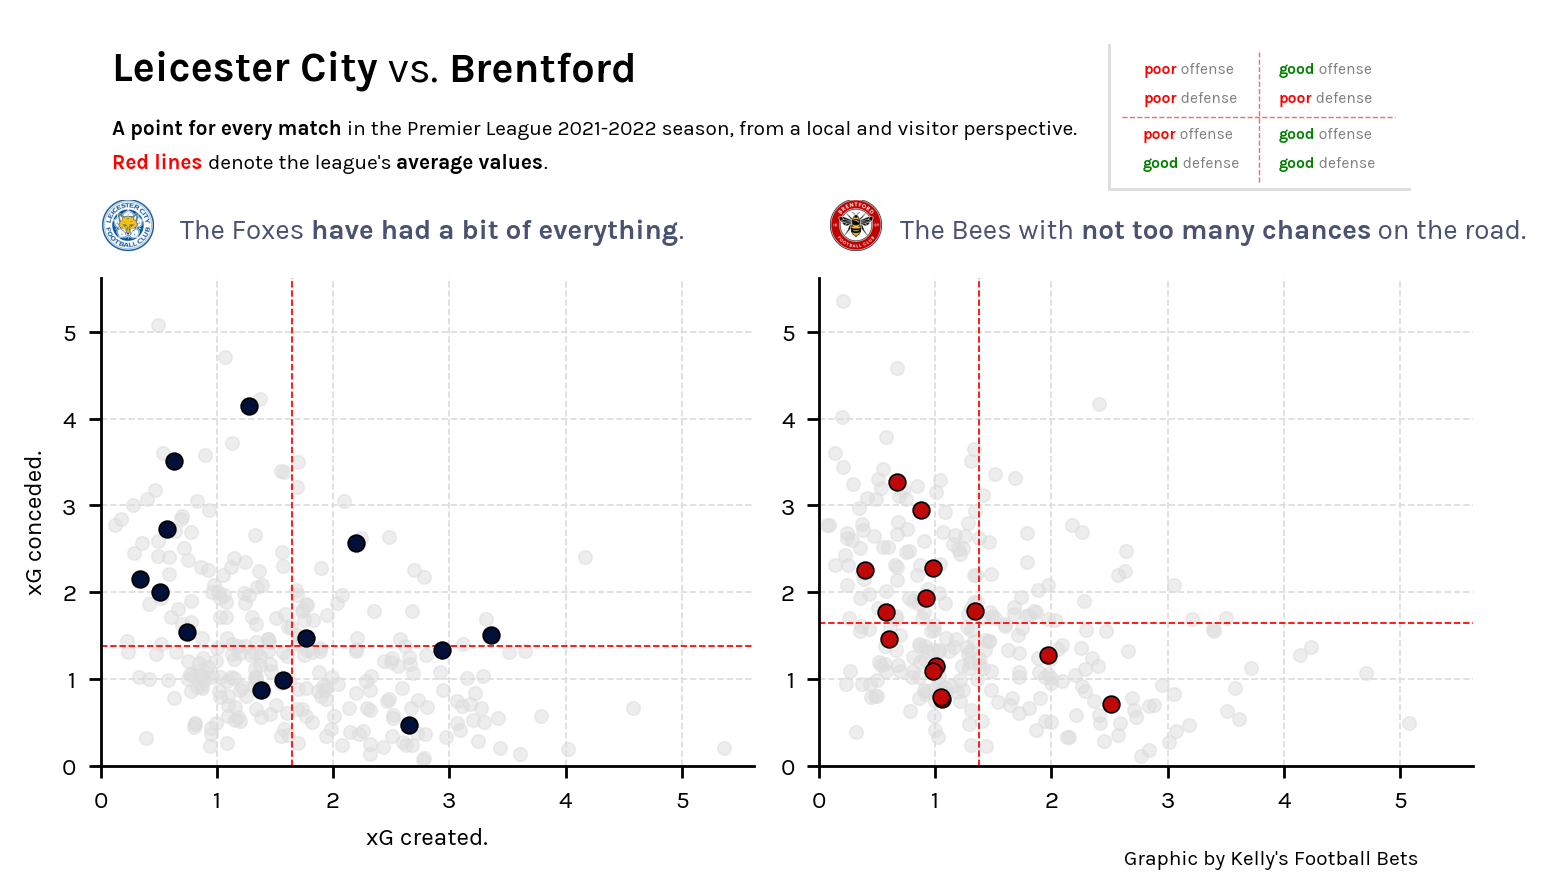

In [303]:
fig = plt.figure(figsize=(6,2.5), dpi = 250, facecolor="white")
ax = plt.subplot(121)
ax2 = plt.subplot(122)

# ax2.spines["left"].set_visible(False)
# ax2.set(yticklabels=[])  # remove the tick labels
# ax2.tick_params(left=False)

# ------------------------------------------
# Scatter plots
ax.scatter(data[(data["variable"] == "xG_for") & (data["venue"] == "H")]["value"], data[(data["variable"] == "xG_ag")  & (data["venue"] == "H")]["value"],
        zorder = 2,
        color = "#DDDDDD",
        alpha = 0.5,
        lw = 0.5,
        s = 15)
ax.scatter(lei_matches[lei_matches["variable"] == "xG_for"]["value"], lei_matches[lei_matches["variable"] == "xG_ag"]["value"],
        zorder = 3,
        color = "#001038",
        edgecolor = "black",
        lw = 0.5,
        s = 23)

ax2.scatter(data[(data["variable"] == "xG_for") & (data["venue"] == "A")]["value"], data[(data["variable"] == "xG_ag")  & (data["venue"] == "A")]["value"],
        zorder = 2,
        color = "#DDDDDD",
        alpha = 0.5,
        lw = 0.5,
        s = 15)
ax2.scatter(bren_matches[bren_matches["variable"] == "xG_for"]["value"], bren_matches[bren_matches["variable"] == "xG_ag"]["value"],
        zorder = 3,
        color = "#C00808",
        edgecolor = "black",
        lw = 0.5,
        s = 23)


# ------------------------------------------
# Define limits
Lim_max = max(ax.get_xlim()[1], ax.get_ylim()[1], ax2.get_xlim()[1], ax2.get_ylim()[1])
ax.set_xlim(0, Lim_max)
ax2.set_xlim(0, Lim_max)
ax.set_ylim(0, Lim_max)
ax2.set_ylim(0, Lim_max)

# ------------------------------------------
# Means

mean_for_home = data[(data["venue"] == "H") & (data["variable"] == "xG_for")]["value"].mean()
mean_ag_home = data[(data["venue"] == "H") & (data["variable"] == "xG_ag")]["value"].mean()
mean_for_away = data[(data["venue"] == "A") & (data["variable"] == "xG_for")]["value"].mean()
mean_ag_away = data[(data["venue"] == "A") & (data["variable"] == "xG_ag")]["value"].mean()

ax.plot([mean_for_home,mean_for_home],[0,Lim_max], ls = "--", color = "red", marker = "", lw = 0.5, zorder = 2)
ax.plot([0,Lim_max],[mean_ag_home,mean_ag_home], ls = "--", color = "red", marker = "", lw = 0.5, zorder = 2)

ax2.plot([mean_for_away,mean_for_away],[0,Lim_max], ls = "--", color = "red", marker = "", lw = 0.5, zorder = 2)
ax2.plot([0,Lim_max],[mean_ag_away,mean_ag_away], ls = "--", color = "red", marker = "", lw = 0.5, zorder = 2)

# ------------------------------------------
# Team icons

team_icon = Image.open(urllib.request.urlopen(f"https://images.fotmob.com/image_resources/logo/teamlogo/{8197}.png"))
team_ax = fig.add_axes([0.045, 1, 0.082, 0.082], zorder=1)
team_ax.imshow(team_icon)
team_ax.axis("off")

ax_text(x = 0.12, y = 1.08,
s = f"The Foxes <have had a bit of everything>.",
highlight_textprops=[{"weight":"bold"}],
ax = ax, weight = "normal", ha = "left", size = 8, color = "#495371",annotationbbox_kw = {"xycoords":"figure fraction"})

ax_text(x = 0.6, y = 1.08,
s = f"The Bees with <not too many chances> on the road.",
highlight_textprops=[{"weight":"bold"}],
ax = ax, weight = "normal", ha = "left", size = 8, color = "#495371",annotationbbox_kw = {"xycoords":"figure fraction"})


team_icon = Image.open(urllib.request.urlopen(f"https://images.fotmob.com/image_resources/logo/teamlogo/{9937}.png"))
team_ax = fig.add_axes([0.53, 1, 0.082, 0.082], zorder=1)
team_ax.imshow(team_icon)
team_ax.axis("off")

# -----------------------
# Titles and other stuff
ax.xaxis.set_label_text("xG created.")
ax.yaxis.set_label_text("xG conceded.")


ax_text(x = 0.075, y = 1.35,
        s = "<Leicester City> vs. <Brentford>",
        highlight_textprops=[{"weight":"bold"}, {"weight":"bold"}],
        ax = ax, weight = "normal", ha = "left", size = 12, annotationbbox_kw = {"xycoords":"figure fraction"})

ax_text(x = 0.075, y = 1.24,
        s = "<A point for every match> in the Premier League 2021-2022 season, from a local and visitor perspective.\n<Red lines> denote the league's <average values>.",
        highlight_textprops=[{"weight":"bold"}, {"weight":"bold", "color":"red"}, {"weight":"bold"}],
        ax = ax, weight = "normal", ha = "left", size = 6, annotationbbox_kw = {"xycoords":"figure fraction"})

# -----------------------
# Legend ax
legend_ax = fig.add_axes([0.74, 1.1, 0.2, 0.23], zorder=1)
legend_ax.spines["left"].set_color("#DDDDDD")
legend_ax.spines["bottom"].set_color("#DDDDDD")
legend_ax.set_xticks([])
legend_ax.set_yticks([])
legend_ax.set_xticklabels([])
legend_ax.set_yticklabels([])
legend_ax.plot([0.5,0.5],[0,1], ls = "--", color = "red", marker = "", lw = 0.4, zorder = 2, alpha = 0.6)
legend_ax.plot([0,1],[0.5,0.5], ls = "--", color = "red", marker = "", lw = 0.4, zorder = 2, alpha = 0.6)

ax_text(x = 0.75, y = 0.75,
        s = "<good> offense \n<poor> defense",
        highlight_textprops=[{"weight":"bold","color":"green"}, {"weight":"bold","color":"red"}],
        ax = legend_ax, weight = "normal", ha = "center", color = "gray", va = "center", size = 4.5, annotationbbox_kw = {"xycoords":"data"})

ax_text(x = 0.25, y = 0.75,
        s = "<poor> offense \n<poor> defense",
        highlight_textprops=[{"weight":"bold","color":"red"}, {"weight":"bold","color":"red"}],
        ax = legend_ax, weight = "normal", ha = "center", color = "gray", va = "center", size = 4.5, annotationbbox_kw = {"xycoords":"data"})

ax_text(x = 0.25, y = 0.25,
        s = "<poor> offense \n<good> defense",
        highlight_textprops=[{"weight":"bold","color":"red"}, {"weight":"bold","color":"green"}],
        ax = legend_ax, weight = "normal", ha = "center", va = "center", color = "gray", size = 4.5, annotationbbox_kw = {"xycoords":"data"})

ax_text(x = 0.75, y = 0.25,
        s = "<good> offense \n<good> defense",
        highlight_textprops=[{"weight":"bold","color":"green"}, {"weight":"bold","color":"green"}],
        ax = legend_ax, weight = "normal", ha = "center", va = "center", color = "gray", size = 4.5, annotationbbox_kw = {"xycoords":"data"})


plt.tight_layout()
fig.text(0.75, 0.02, "Graphic by Kelly's Football Bets", fontsize=6)

plt.savefig(
f"visualizations/plots/the_notepad/03202022/lei_bre.png",
dpi=250,
bbox_inches="tight",
edgecolor="none",
transparent=False,
)